In [1]:
import os
os.chdir('C:\\Satyaki\\hackathons\\AV_interest_rate_prediction')

In [2]:
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.utils import np_utils
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,OneHotEncoder,LabelEncoder
from sklearn.model_selection import train_test_split,KFold,cross_val_score,GridSearchCV
from sklearn.metrics import accuracy_score,f1_score 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [3]:
from sklearn.linear_model import LogisticRegression

In [4]:
df_train=pd.read_csv('train_fNxu4vz.csv',index_col='Loan_ID',thousands=',')
df_test=pd.read_csv('test_fjtUOL8.csv',index_col='Loan_ID',thousands=',')

In [5]:
df_train.head()

,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Gender,Interest_Rate
Loan_ID,,,,,,,,,,,,,
10000001,7000,< 1 year,Rent,68000.0,not verified,car,18.37,0,NaN,9,14,Female,1
10000002,30000,4 years,Mortgage,NaN,VERIFIED - income,debt_consolidation,14.93,0,17.0,12,24,Female,3
10000003,24725,7 years,Mortgage,75566.4,VERIFIED - income source,debt_consolidation,15.88,0,NaN,12,16,Male,3
10000004,16000,< 1 year,NaN,56160.0,VERIFIED - income source,debt_consolidation,14.34,3,NaN,16,22,Male,3
10000005,17000,8 years,Own,96000.0,VERIFIED - income source,debt_consolidation,22.17,1,NaN,19,30,Female,1


In [6]:
df_test.head()

,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Gender
Loan_ID,,,,,,,,,,,,
10164310,27500,10+ years,Mortgage,129000.0,VERIFIED - income,debt_consolidation,12.87,0,68.0,10,37,Male
10164311,26000,10+ years,NaN,110000.0,not verified,credit_card,11.37,0,NaN,6,23,Male
10164312,6075,< 1 year,Rent,75000.0,VERIFIED - income,debt_consolidation,6.83,2,NaN,5,20,Male
10164313,12000,10+ years,Mortgage,73000.0,VERIFIED - income source,debt_consolidation,7.76,0,NaN,6,8,Male
10164314,35000,< 1 year,Mortgage,156000.0,not verified,debt_consolidation,9.62,0,26.0,9,21,Male


In [7]:
print('train_shape:',df_train.shape)
print('test_shape:',df_test.shape)

train_shape: (164309, 13)
test_shape: (109541, 12)


In [8]:
df_train.dtypes

Loan_Amount_Requested        int64
Length_Employed             object
Home_Owner                  object
Annual_Income              float64
Income_Verified             object
Purpose_Of_Loan             object
Debt_To_Income             float64
Inquiries_Last_6Mo           int64
Months_Since_Deliquency    float64
Number_Open_Accounts         int64
Total_Accounts               int64
Gender                      object
Interest_Rate                int64
dtype: object

### Cleaning and preprocessing

In [9]:
df_train.isnull().sum()/df_train.shape[0]

Loan_Amount_Requested      0.000000
Length_Employed            0.044861
Home_Owner                 0.154276
Annual_Income              0.152773
Income_Verified            0.000000
Purpose_Of_Loan            0.000000
Debt_To_Income             0.000000
Inquiries_Last_6Mo         0.000000
Months_Since_Deliquency    0.537883
Number_Open_Accounts       0.000000
Total_Accounts             0.000000
Gender                     0.000000
Interest_Rate              0.000000
dtype: float64

In [10]:
df_train['Length_Employed'].replace({'< 1 year':'0 years','10+ years':'11 years'},inplace=True)
df_test['Length_Employed'].replace({'< 1 year':'0 years','10+ years':'11 years'},inplace=True)

In [11]:
a=df_train['Length_Employed'].mode()
b=df_test['Length_Employed'].mode()
df_train['Length_Employed']=df_train['Length_Employed'].fillna(a.values[0]).astype('string').map(lambda x: x.rstrip('years')).astype('float')
df_test['Length_Employed']=df_test['Length_Employed'].fillna(b.values[0]).astype('string').map(lambda x: x.rstrip('years')).astype('float')

In [12]:
# since 47% values here are missing, it can be assumed that these borrowers were never late for their payments.
# So na values can be replaced with -1
df_train['Months_Since_Deliquency']=df_train['Months_Since_Deliquency'].fillna(-1)
df_test['Months_Since_Deliquency']=df_test['Months_Since_Deliquency'].fillna(-1)

### Creating new Features

In [13]:
# Repayment Period
eps=0.001
df_train['Repayment_period']=df_train['Loan_Amount_Requested']/(df_train['Annual_Income']+eps)
df_test['Repayment_period']=df_test['Loan_Amount_Requested']/(df_test['Annual_Income']+eps)

In [14]:
# number of redundant accounts
df_train['Number_of_redundant_accounts']=df_train['Total_Accounts']-df_train['Number_Open_Accounts']
df_test['Number_of_redundant_accounts']=df_test['Total_Accounts']-df_test['Number_Open_Accounts']

#### organizing data into numeric and categorical attributes

In [15]:
catcols=['Gender', 'Home_Owner', 'Income_Verified', 'Purpose_Of_Loan','Inquiries_Last_6Mo','Length_Employed']
numcols=df_train.columns.difference(catcols).drop('Interest_Rate')  
df_train[catcols]=df_train[catcols].astype('category')
df_test[catcols]=df_test[catcols].astype('category')

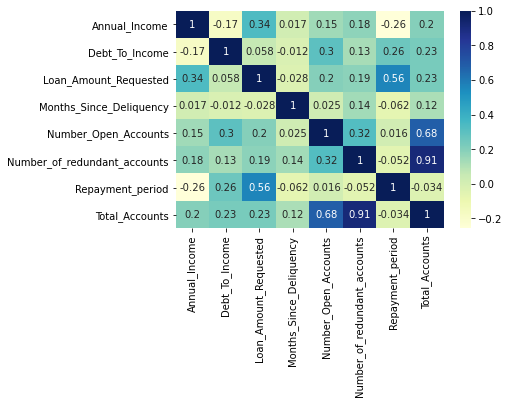

In [16]:
corr=df_train[numcols].corr()
sns.heatmap(corr,cmap='YlGnBu',annot=True)

In [17]:
X,y=df_train.loc[:,df_train.columns!='Interest_Rate'],df_train['Interest_Rate']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=23)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(131447, 14) (131447,)
(32862, 14) (32862,)


## Model Building

In [18]:
%%time
num_transformer=Pipeline(steps=[
    ('num_imputer',SimpleImputer(strategy='median')),
    ('scaler',StandardScaler())
])

cat_transformer=Pipeline(steps=[
    ('cat_imputer',SimpleImputer(strategy='most_frequent')),
    ('onehot',OneHotEncoder(handle_unknown='ignore'))
])

preprocessor=ColumnTransformer(transformers=[
    ('num',num_transformer,numcols),
    ('cat',cat_transformer,catcols)
])

preprocessor.fit(X_train)

Wall time: 1min 18s


ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('num_imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 Index(['Annual_Income', 'Debt_To_Income', 'Loan_Amount_Requested',
       'Months_Since_Deliquency', 'Number_Open_Accounts',
       'Number_of_redundant_accounts', 'Repayment_period', 'Total_Accounts'],
      dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('cat_imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Gender', 'Home_Owner', 'Income_Verified',
                                  'Purpose

In [19]:
X_train1=preprocessor.transform(X_train)
X_test1=preprocessor.transform(X_test)
df_test1=preprocessor.transform(df_test)

In [20]:
# encoding target variable
encoder=LabelEncoder()
encoder.fit(y_train)
enc_y=encoder.transform(y_train)
y_train1 = np_utils.to_categorical(enc_y)

In [21]:
print(X_train1.shape)
print(X_test1.shape)
print(df_test1.shape)

(131447, 52)
(32862, 52)
(109541, 52)


In [22]:
#defining function for model evaluation
def model_eval(model,X_train=X_train1,y_train=y_train,X_test=X_test1,y_test=y_test):
    pred_train=model.predict(X_train)
    pred_test=model.predict(X_test)
    print('\n')
    print('Train accuracy:',accuracy_score(y_train,pred_train))
    print('Train F1 score:',f1_score(y_train,pred_train,average='weighted'))
    print('--'*30)
    print('Test accuracy:',accuracy_score(y_test,pred_test))
    print('Test F1 score:',f1_score(y_test,pred_test,average='weighted'))

## MLP with no hidden layer

In [28]:
model1=Sequential()
model1.add(Dense(3,input_dim=52,activation='softmax',kernel_initializer='normal'))

In [29]:
model1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 3)                 159       
Total params: 159
Trainable params: 159
Non-trainable params: 0
_________________________________________________________________


In [30]:
model1.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [31]:
model1.fit(X_train1,y_train1,epochs=20,batch_size=64)

Epoch 1/20
131447/131447 [==============================] - 6s 48us/step - loss: 0.9711 - accuracy: 0.5115
Epoch 2/20
131447/131447 [==============================] - 6s 42us/step - loss: 0.9581 - accuracy: 0.5201
Epoch 3/20
131447/131447 [==============================] - 6s 43us/step - loss: 0.9577 - accuracy: 0.5204
Epoch 4/20
131447/131447 [==============================] - 6s 43us/step - loss: 0.9576 - accuracy: 0.5205
Epoch 5/20
131447/131447 [==============================] - 6s 43us/step - loss: 0.9575 - accuracy: 0.5210
Epoch 6/20
131447/131447 [==============================] - 6s 45us/step - loss: 0.9574 - accuracy: 0.5208
Epoch 7/20
131447/131447 [==============================] - 6s 43us/step - loss: 0.9575 - accuracy: 0.5209
Epoch 8/20
131447/131447 [==============================] - 6s 43us/step - loss: 0.9575 - accuracy: 0.5209
Epoch 9/20
131447/131447 [==============================] - 6s 44us/step - loss: 0.9575 - accuracy: 0.5202
Epoch 10/20
131447/131447 [==========

## MLP with 3 hidden layers

In [33]:
def baseline_model(lr=0.002):
    adam=optimizers.adam(lr=lr)
    model=Sequential()
    model.add(Dense(40,input_dim=52,activation='relu',kernel_initializer='normal'))
    model.add(Dense(20,activation='relu',kernel_initializer='normal'))
    model.add(Dense(10,activation='relu',kernel_initializer='normal'))
    model.add(Dense(3,activation='softmax',kernel_initializer='normal'))
    model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])
    return model

In [34]:
estimator=KerasClassifier(build_fn=baseline_model,epochs=10,batch_size=64,verbose=1)

In [35]:
estimator.fit(X_train1,y_train)

Epoch 1/10
131447/131447 [==============================] - 8s 59us/step - loss: 0.9631 - accuracy: 0.5121
Epoch 2/10
131447/131447 [==============================] - 8s 59us/step - loss: 0.9494 - accuracy: 0.5243
Epoch 3/10
131447/131447 [==============================] - 8s 58us/step - loss: 0.9427 - accuracy: 0.5274
Epoch 4/10
131447/131447 [==============================] - 8s 59us/step - loss: 0.9367 - accuracy: 0.5314
Epoch 5/10
131447/131447 [==============================] - 8s 59us/step - loss: 0.9345 - accuracy: 0.5330
Epoch 6/10
131447/131447 [==============================] - 8s 59us/step - loss: 0.9327 - accuracy: 0.5332
Epoch 7/10
131447/131447 [==============================] - 8s 58us/step - loss: 0.9314 - accuracy: 0.5342
Epoch 8/10
131447/131447 [==============================] - 8s 59us/step - loss: 0.9301 - accuracy: 0.5351
Epoch 9/10
131447/131447 [==============================] - 8s 59us/step - loss: 0.9290 - accuracy: 0.5351
Epoch 10/10
131447/131447 [==========

In [36]:
model_eval(estimator)

32862/32862 [==============================] - 1s 17us/step


Train accuracy: 0.5385516596042511
Train F1 score: 0.5326282632548366
------------------------------------------------------------
Test accuracy: 0.5277828494918142
Test F1 score: 0.5219336786019915


In [37]:
### finding optimal learning Rate
learning_rate=np.logspace(-5,-2,10)
hist_loss=[]
for k in learning_rate:
    new_model=baseline_model(lr=k)
    model_history=new_model.fit(X_train1,y_train1,epochs=10,batch_size=64,verbose=0)
    hist_loss.append(model_history.history['loss'][9])

Text(0, 0.5, 'Loss value')

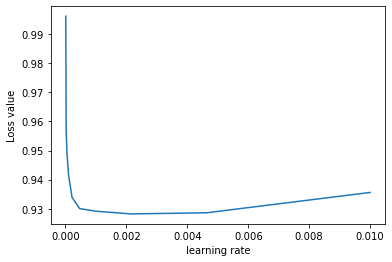

In [40]:
plt.plot(learning_rate,hist_loss)
plt.xlabel('learning rate')
plt.ylabel('Loss value')

### Logistic regression

In [41]:
lr=LogisticRegression(n_jobs=3,random_state=23)
lr.fit(X_train1,y_train)
model_eval(lr)



Train accuracy: 0.5216170776054228
Train F1 score: 0.5001307141312626
------------------------------------------------------------
Test accuracy: 0.5147891181303633
Test F1 score: 0.49380442042365785


### exporting solution

In [ ]:
test_index=df_test.index
pred=estimator.predict(df_test2)
result=pd.DataFrame({'Loan_ID':test_index,'Interest_Rate':pred}).set_index('Loan_ID')
result.to_csv('result.csv',index=True,header=True)